In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from scipy.stats.distributions import chi2
from sklearn.preprocessing import StandardScaler
import pymysql

In [30]:
tem_component_code=['hw3', 'hw2', 'hw1','[TEMP_DIFF:hw1,hw2,hw3]','[TEMP_DIFF:3-1,3-2,3-4]','[TEMP_DIFF:2-1,2-2,2-3]','3-4','3-2','3-1','2-5','2-4','2-3','2-2','2-1']
pres_component_code=['3-7','3-6','3-4','3-2','3-1','2-7','2-6','2-5','2-4','2-3','2-2','2-1']
tem_component_results=[]
pres_component_results=[]
equipment='equipment_switch_36'
if equipment=='equipment_switch_36':
    vector=26
# # 装载已经训练好的模型
SPE_limit=6
pca=joblib.load('gis_diagnosis_pca.pkl')
scaler=joblib.load('gis_diagnosis_scaler.pkl')

In [64]:
# 打开数据库连接
db = pymysql.connect("localhost","root","0502","robot" )
 
# 使用 cursor() 方法创建一个游标对象 cursor
cursor = db.cursor()
sql_get_tem_value="select c_observation_value from fault_detection_value where c_equipment_id= %s and c_component_code = %s and c_distinguish_type_id='infrared' and c_state=1 and fault='normal'"
sql_get_pres_value="select c_observation_value from fault_detection_value where c_equipment_id= %s and c_component_code = %s and c_distinguish_type_id='meterReading' and c_state=1"
try:
    for component_code in tem_component_code:
        cursor.execute(sql_get_tem_value,('equipment_switch_36',component_code))
        tem_component_results.append(cursor.fetchall())
    for component_code in pres_component_code:
        cursor.execute(sql_get_pres_value,('equipment_switch_36',component_code))
        pres_component_results.append(cursor.fetchall())
except Exception as e:
 #错误回滚
    db.rollback() 
finally:
    db.close() 

In [65]:
for i in range(len(tem_component_results)):
    print('温度表计%d共成功采集%d个数据' %(i,len(tem_component_results[i])))
print("\n")
for i in range(len(pres_component_results)):
    print('压力表计%d共成功采集%d个数据' %(i,len(pres_component_results[i])))

温度表计0共成功采集14个数据
温度表计1共成功采集15个数据
温度表计2共成功采集12个数据
温度表计3共成功采集7个数据
温度表计4共成功采集10个数据
温度表计5共成功采集13个数据
温度表计6共成功采集23个数据
温度表计7共成功采集23个数据
温度表计8共成功采集20个数据
温度表计9共成功采集15个数据
温度表计10共成功采集12个数据
温度表计11共成功采集20个数据
温度表计12共成功采集24个数据
温度表计13共成功采集18个数据


压力表计0共成功采集23个数据
压力表计1共成功采集21个数据
压力表计2共成功采集15个数据
压力表计3共成功采集12个数据
压力表计4共成功采集15个数据
压力表计5共成功采集23个数据
压力表计6共成功采集24个数据
压力表计7共成功采集11个数据
压力表计8共成功采集7个数据
压力表计9共成功采集12个数据
压力表计10共成功采集12个数据
压力表计11共成功采集15个数据


# 如果机器人全部采集完一轮，才记为一条数据的话,一共才只有7条数据，过于稀疏

# 如果每次成功采集一个表计，都算作一条新数据的话

In [73]:
#数据矩阵
x=np.empty((1,vector))

#温度初始值
tem_def = {'hw3' : 28.5, 'hw2' : 28.5,'hw1' : 27.0,'[TEMP_DIFF:hw1,hw2,hw3]' : 1,'[TEMP_DIFF:3-1,3-2,3-4]' : 1.5,'[TEMP_DIFF:2-1,2-2,2-3]' : 2.0,'3-4' : 30.0,'3-2' : 30.0,'3-1' : 29.3,'2-5' : 33.8,'2-4' : 32.25,'2-3' : 34.12,'2-2' : 35,'2-1' : 35.8}
#压力初始值
pres_def = {'3-7' : 69, '3-6' : 0.05,'3-4' : 1.13,'3-2' : 0.17,'3-1' : 0.257,'2-7' : 30.0,'2-6' : 0.028,'2-5' : 36.6,'2-4' : 2.0,'2-3' : 3.124,'2-2' : 1.9,'2-1' : 0.0853}    
tem_latest=tem_def
pres_latest=pres_def

one_shoot_dataset=[]

In [74]:
while(True):

    # 打开数据库连接

    db = pymysql.connect("localhost","root","0502","robot" )

    # 使用 cursor() 方法创建一个游标对象 cursor
    cursor = db.cursor()
    #查找预测值为空且时间最远的一条数据
    sql_get_value="select min(d_create_time),c_observation_value,c_component_code,c_distinguish_type_id from fault_detection_value where c_equipment_id='"+equipment+"' and equipment_fault_prob is null and c_observation_value != 'ON' and c_observation_value != 'OFF' and c_state=1 and c_component_code not like '%REF%'"

    try:
        cursor.execute(sql_get_value)
        latest_data=cursor.fetchall()
    except Exception as e:
    #错误回滚
        db.rollback() 
    finally:
        db.close() 

    if latest_data[0][0]== None: 
        break

    #下面如果取消注释，那么就会变成针对单个compoment的检测，而不是针对设备的检测
    # #温度当前值
    # tem_latest =tem_def
    # #压力当前值
    # pres_latest = pres_def


    if latest_data[0][3]=='meterReading':
        pres_latest[latest_data[0][2]]=latest_data[0][1]
    elif latest_data[0][3]=='infrared':
        tem_latest[latest_data[0][2]]=latest_data[0][1]

    #建立数据
    i=0
    for value in tem_latest.values():
        x[0][i]=value
        i+=1
    for value in pres_latest.values():
        x[0][i]=value
        i+=1


    # # 开始训练

    x_scaled=scaler.transform(x)
    x_rec=pca.inverse_transform(pca.transform(x_scaled))
    res=x_scaled-x_rec
    spe=float(np.diag(np.dot(res,np.transpose(res))))
    # #将spe转化成故障率
    # if spe <= SPE_limit and spe!=0:
    #     spe=spe ** 0.5 *50 / (SPE_limit**0.5)
    # elif spe > SPE_limit: 
    #     spe=(spe-SPE_limit)
    # else: 
    #     spe=99.99
    if spe<6:
        one_shoot_dataset.append(x)

    db = pymysql.connect("localhost","root","0502","robot" )
    # 使用 cursor() 方法创建一个游标对象 cursor
    cursor = db.cursor()
    #查找预测值为空且时间最远的一条数据
    sql_diagnosis="update fault_detection_value set equipment_fault_prob='"+str(float(spe))+"' where d_create_time='"+str(latest_data[0][0])+"' and c_equipment_id='"+equipment+"' and equipment_fault_prob is null and c_observation_value != 'ON' and c_observation_value != 'OFF' and c_state=1 and c_component_code not like '%REF%'"

    try:
        cursor.execute(sql_diagnosis)
        db.commit()
    except Exception as e:
    #错误回滚
        db.rollback() 
    finally:
        db.close() 

# 一共得到了209条正常数据，让我们来可视化它们

In [75]:
one_shoot_dataset=np.array(one_shoot_dataset)
one_shoot_dataset=np.squeeze(one_shoot_dataset)
print(one_shoot_dataset.shape)

(209, 26)


In [76]:
from sklearn.manifold import TSNE
one_shoot_dataset_embedded = TSNE(n_components=2).fit_transform(one_shoot_dataset)

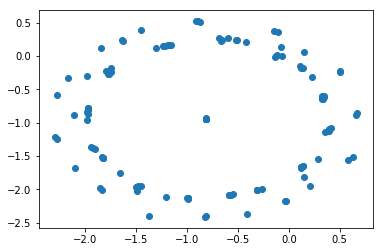

In [77]:
import matplotlib.pyplot as plt
plt.scatter(one_shoot_dataset_embedded[:,0],one_shoot_dataset_embedded[:,1])

# 如果采用基于特征池的随机采样方法，同样随机采209个数据

In [86]:
random_shoot_dataset=np.empty([209,26]) 
for i in range(random_shoot_dataset.shape[0]):
    for j in range(len(tem_component_results)):
        random_shoot_dataset[i][j]=tem_component_results[j][np.random.randint(len(tem_component_results[j]))][0]
    for k in range(len(pres_component_results)):
        random_shoot_dataset[i][k+len(tem_component_results)]=pres_component_results[k][np.random.randint(len(pres_component_results[k]))][0]

In [87]:
print(random_shoot_dataset.shape)

(209, 26)


In [88]:
random_shoot_dataset_embedded = TSNE(n_components=2).fit_transform(random_shoot_dataset)

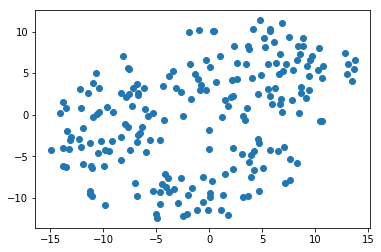

In [89]:
plt.scatter(random_shoot_dataset_embedded[:,0],random_shoot_dataset_embedded[:,1])